##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [64]:
#!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import  nltk.translate.bleu_score as bleu

## Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Create a custom subwords tokenizer from the training dataset. 

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [9]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: To keep this example small and relatively fast, drop examples with a length of over 40 tokens.

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [12]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))        

Pad and batch examples together:

In [13]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [14]:
# train_dataset = (train_preprocessed
#                  .padded_batch(BATCH_SIZE)
#                  .prefetch(tf.data.experimental.AUTOTUNE))


# val_dataset = (val_preprocessed
#                .padded_batch(BATCH_SIZE))

Get an batch from the validation set to test the code on later:

In [15]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]], dtype=int64)>)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [16]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


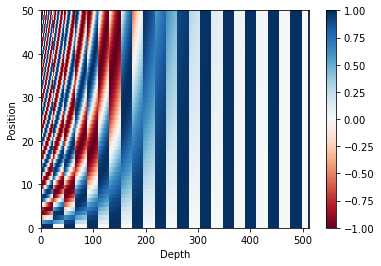

In [18]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [19]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [20]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [22]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [24]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [25]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [26]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [28]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [30]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [31]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [32]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [33]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [34]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [36]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [37]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [38]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [39]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [40]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [41]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [42]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [43]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

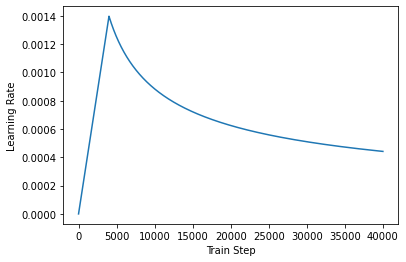

In [46]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [50]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [51]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [53]:
EPOCHS = 20

In [54]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [55]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3328 Accuracy 0.3911
Epoch 1 Batch 50 Loss 0.3009 Accuracy 0.4314
Epoch 1 Batch 100 Loss 0.3009 Accuracy 0.4305
Epoch 1 Batch 150 Loss 0.3050 Accuracy 0.4301
Epoch 1 Batch 200 Loss 0.3093 Accuracy 0.4298
Epoch 1 Batch 250 Loss 0.3131 Accuracy 0.4297
Epoch 1 Batch 300 Loss 0.3157 Accuracy 0.4295
Epoch 1 Batch 350 Loss 0.3188 Accuracy 0.4299
Epoch 1 Batch 400 Loss 0.3215 Accuracy 0.4290
Epoch 1 Batch 450 Loss 0.3244 Accuracy 0.4287
Epoch 1 Batch 500 Loss 0.3268 Accuracy 0.4285
Epoch 1 Batch 550 Loss 0.3292 Accuracy 0.4282
Epoch 1 Batch 600 Loss 0.3316 Accuracy 0.4282
Epoch 1 Batch 650 Loss 0.3340 Accuracy 0.4274
Epoch 1 Batch 700 Loss 0.3360 Accuracy 0.4274
Epoch 1 Loss 0.3361 Accuracy 0.4273
Time taken for 1 epoch: 61.607985734939575 secs

Epoch 2 Batch 0 Loss 0.3194 Accuracy 0.4927
Epoch 2 Batch 50 Loss 0.3001 Accuracy 0.4305
Epoch 2 Batch 100 Loss 0.3022 Accuracy 0.4282
Epoch 2 Batch 150 Loss 0.3040 Accuracy 0.4278
Epoch 2 Batch 200 Loss 0.3071 Accuracy 0.4276
E

Epoch 11 Batch 400 Loss 0.3066 Accuracy 0.4306
Epoch 11 Batch 450 Loss 0.3093 Accuracy 0.4303
Epoch 11 Batch 500 Loss 0.3117 Accuracy 0.4298
Epoch 11 Batch 550 Loss 0.3150 Accuracy 0.4289
Epoch 11 Batch 600 Loss 0.3175 Accuracy 0.4286
Epoch 11 Batch 650 Loss 0.3197 Accuracy 0.4287
Epoch 11 Batch 700 Loss 0.3216 Accuracy 0.4284
Epoch 11 Loss 0.3216 Accuracy 0.4284
Time taken for 1 epoch: 39.10159945487976 secs

Epoch 12 Batch 0 Loss 0.2945 Accuracy 0.4202
Epoch 12 Batch 50 Loss 0.2856 Accuracy 0.4244
Epoch 12 Batch 100 Loss 0.2888 Accuracy 0.4278
Epoch 12 Batch 150 Loss 0.2913 Accuracy 0.4279
Epoch 12 Batch 200 Loss 0.2944 Accuracy 0.4280
Epoch 12 Batch 250 Loss 0.2967 Accuracy 0.4274
Epoch 12 Batch 300 Loss 0.2991 Accuracy 0.4285
Epoch 12 Batch 350 Loss 0.3024 Accuracy 0.4293
Epoch 12 Batch 400 Loss 0.3042 Accuracy 0.4293
Epoch 12 Batch 450 Loss 0.3066 Accuracy 0.4286
Epoch 12 Batch 500 Loss 0.3092 Accuracy 0.4289
Epoch 12 Batch 550 Loss 0.3121 Accuracy 0.4288
Epoch 12 Batch 600 Loss 0

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [56]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [57]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [58]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)
    
  return predicted_sentence

In [59]:
pred_sent = translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")
ref_sent = 'this is a problem we have to solve .'

Input: este é um problema que temos que resolver.
Predicted translation: so this is one problem that we have to deal with it .
Real translation: this is a problem we have to solve .


In [60]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea as a thing to do just glance .
Real translation: and my neighboring homes heard about this idea .


In [61]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to quickly share with you a few stories of some magical things that happened there .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

Input: este é o primeiro livro que eu fiz.
Predicted translation: so that 's the first book i did .


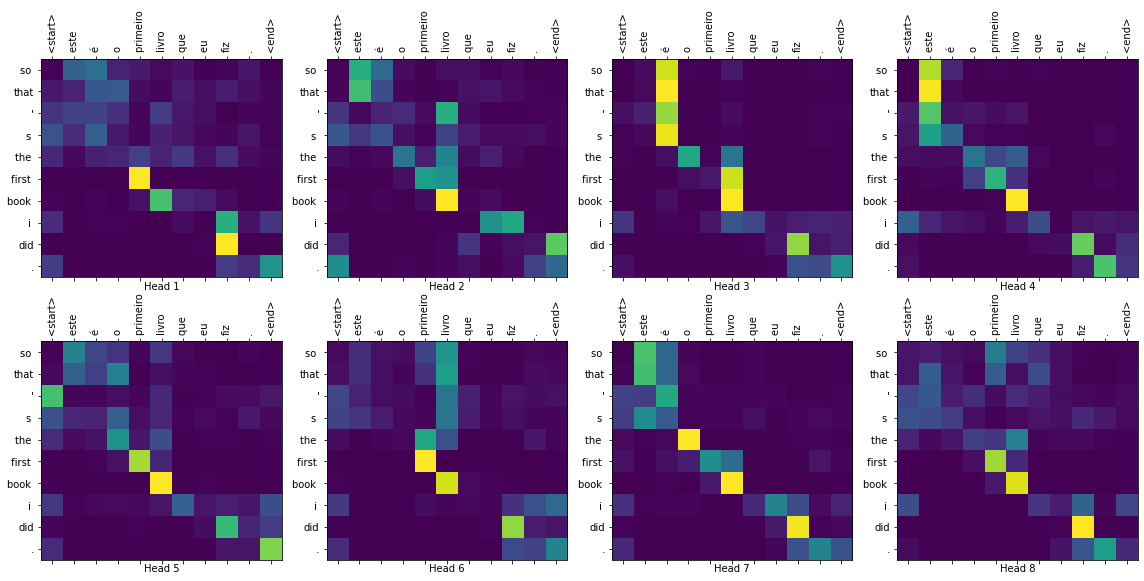

Real translation: this is the first book i've ever done.


In [62]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.

In [65]:
bleuplus = 0

for pt_, en_ in val_examples:
    pt_test = pt_.numpy().decode("utf-8", "ignore")
    predicted = translate(pt_test)
    en_test = en_.numpy().decode("utf-8", "ignore")
    print('Real translation: {}'.format(en_test))
    bleu_ = bleu.sentence_bleu([en_test.split()], predicted.split(), weights=(1, 0, 0, 0))
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_

Input: tinham comido peixe com batatas fritas ?
Predicted translation: had you eated off with chips ?
Real translation: did they eat fish and chips ?
BLEU Score:  0.2857142857142857
--------------------------------------------------------------------------------


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input: estava sempre preocupado em ser apanhado e enviado de volta .
Predicted translation: i was always concerned about being caught up and sent back .
Real translation: i was always worried about being caught and sent back .
BLEU Score:  0.8333333333333334
--------------------------------------------------------------------------------
Input: escolhi um com o tom de pele de uma lagosta com um escaldão .
Predicted translation: i chose a blower of a lake from a scandal .
Real translation: i chose one with the skin color of a lobster when sunburnt .
BLEU Score:  0.378978599125082
--------------------------------------------------------------------------------
Input: mas eu penso que isto é claramente falso .
Predicted translation: but i think this is clearly fake .
Real translation: but i think this is quite clearly untrue .
BLEU Score:  0.772184789761521
--------------------------------------------------------------------------------
Input: temos medido o nosso progresso muito rigorosa

C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input: a estrutura tem apenas cinco metros de altura e sete andares .
Predicted translation: the structure is only five meters tall and seven floors .
Real translation: the building is only five meters tall with seven floors .
BLEU Score:  0.8181818181818182
--------------------------------------------------------------------------------
Input: ok , se existe algo mais estranho penso que tem que ser a energia negra .
Predicted translation: okay , if there is something more strange that i think has to be the dark energy .
Real translation: okay , if there 's anything stranger i think it has to be dark energy .
BLEU Score:  0.6666666666666666
--------------------------------------------------------------------------------
Input: trabalhei para a guarda costeira , fui embaixador da boa vontade da onu .
Predicted translation: i worked and went off to store my again as a torn ups from the course of the on .
Real translation: i worked for the coastguard , was made a u.n. goodwill ambassador 

Input: por isso , juntei tudo .
Predicted translation: so i joined everything .
Real translation: so i set up everything .
BLEU Score:  0.6549846024623855
--------------------------------------------------------------------------------
Input: o que quer que aconteça , não desistam .
Predicted translation: and whatever turns out , they did n't give up over .
Real translation: whatever happens , do n't give up .
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: alguns são mais sobre assuntos sociais , outros mais sobre assuntos económicos .
Predicted translation: some more spiders are about social things , and some others about economic things .
Real translation: some games are more about social issues , some are more about economic issues .
BLEU Score:  0.6666666666666666
--------------------------------------------------------------------------------
Input: e na realidade , se olharem atentamente poderão ver anéis à volta deste agl

Input: e penso que existem quatro tipos principais , e o primeiro tipo que quero descrever é analisar o muito grande .
Predicted translation: and i think there are four main types of facts , and the first part i want to describe is to look at the very big number .
Real translation: and i think there are four major types , and the first type that i want to describe is probing the very big .
BLEU Score:  0.7142857142857143
--------------------------------------------------------------------------------
Input: ora , alice teve dificuldades em obter financiamento para a sua pesquisa .
Predicted translation: now , alice had tricky to adopt in her research .
Real translation: now , alice had trouble getting funding for her research .
BLEU Score:  0.6363636363636364
--------------------------------------------------------------------------------
Input: para onde estás a olhar ?
Predicted translation: where are you looking look ?
Real translation: what are you looking at ?
BLEU Score:  0.66666

Input: e quando as cópias do seu questionário começaram a voltar , uma coisa e apenas uma única coisa saltava à vista com o tipo de clareza estatística com que a maioria dos cientistas apenas pode sonhar .
Predicted translation: and when the surveys of questioning their questionnails , one thing only goes back to the only way to the story of referring and for most clarity .
Real translation: and when her carbon copied questionnaire started to come back , one thing and one thing only jumped out with the statistical clarity of a kind that most scientists can only dream of .
BLEU Score:  0.4612101411459368
--------------------------------------------------------------------------------
Input: uma vez , até passei dois meses , no inverno , a trabalhar numa mina de carvão , a 33 metros de profundidade , sem qualquer proteção , até 16 horas por dia .
Predicted translation: once , i even spent two months , the winter in a coal mine mine , 33 meters without any surprising output , either 16 ho

Input: no futuro , a maioria do crime irá acontecer online .
Predicted translation: most of the crime will happen online .
Real translation: in the future , the majority of crime will be happening online .
BLEU Score:  0.4014460713892427
--------------------------------------------------------------------------------
Input: vocês podem hoje apontar e clicar em flor.com e terem a carpete fixe entregue à vossa porta em cinco dias .
Predicted translation: you can see today and click on and floy , and pete got the cool bop here at five days .
Real translation: you can point and click today at flor.com and have cool carpet delivered to your front door in five days .
BLEU Score:  0.5238095238095238
--------------------------------------------------------------------------------
Input: na verdade , ela não precisava de se ter apressado .
Predicted translation: in fact , she needed not to get friendly .
Real translation: in fact , she need not have hurried .
BLEU Score:  0.6
------------------

Input: tbc — para continuar .
Predicted translation: tbc — for continuing .
Real translation: tbc , to be continued .
BLEU Score:  0.3274923012311928
--------------------------------------------------------------------------------
Input: ia ser a atração na nossa loja .
Predicted translation: it was going to be attracted to our own store .
Real translation: it was going to be the highlight of our store .
BLEU Score:  0.7272727272727273
--------------------------------------------------------------------------------
Input: a maior parte da matéria do universo não é feito de átomos .
Predicted translation: and the majority of the universe is not done by atoms .
Real translation: most of the universe 's matter is not made up of atoms .
BLEU Score:  0.5366925752004387
--------------------------------------------------------------------------------
Input: também não há barreiras entre as salas de aula .
Predicted translation: there are also no barrier between classrooms .
Real translation: 

Input: por exemplo , uma nota musical não pode ser captada e totalmente expressa no papel .
Predicted translation: for example , a musical note could n't be captured and fully expressed to paper .
Real translation: for example , a musical note can not be fully captured and expressed on paper .
BLEU Score:  0.8125
--------------------------------------------------------------------------------
Input: não se pode discutir a privacidade .
Predicted translation: if you ca n't discuss privacy concerns .
Real translation: privacy is not up for discussion .
BLEU Score:  0.25
--------------------------------------------------------------------------------
Input: `` no final , obteve apenas 1 000 libras do prémio `` '' lady tata memorial '' '' . ''
Predicted translation: `` in the end , they get only 1,000 pounds of the pre-memorizing the prize . '' ''
Real translation: in the end , she got just 1,000 pounds from the lady tata memorial prize .
BLEU Score:  0.5
----------------------------------

Input: e um lavatório .
Predicted translation: and a washer .
Real translation: and a washbasin .
BLEU Score:  0.75
--------------------------------------------------------------------------------
Input: agora , mostrando-vos algumas destas imagens , espero que rapidamente se apercebam de que os aglomerados de galáxias são belos objetos , mas mais do que isso , penso que os aglomerados de galáxias são misteriosos , surpreendentes e úteis .
Predicted translation: now he shows you some of these images , hopefully that you know that clusters are unified things that are beautiful than that , but the sort of bellies as this as this as this as this 
Real translation: now , by showing you some of these images , i hope that you will quickly see that galaxy clusters are these beautiful objects , but more than that , i think galaxy clusters are mysterious , they are surprising , and they 're useful .
BLEU Score:  0.381444698055253
-----------------------------------------------------------------

Input: mas podíamos manter essa ideia à volta das árvores .
Predicted translation: but we could keep that idea around the trees .
Real translation: but we could keep that idea around the trees .
BLEU Score:  1.0
--------------------------------------------------------------------------------
Input: elas não conseguem pensar juntas .
Predicted translation: they ca n't think together .
Real translation: they ca n't think together .
BLEU Score:  1.0
--------------------------------------------------------------------------------
Input: quando colocamos muitas crianças num espaço silencioso , algumas delas ficam muito nervosas .
Predicted translation: when we put a lot of children into a silent space , some of them are too nerves .
Real translation: when you put many children in a quiet box , some of them get really nervous .
BLEU Score:  0.47368421052631576
--------------------------------------------------------------------------------
Input: então comecei a roubar de carros de comida , 

Input: e a solução que eu ofereço é para o maior culpado deste mau tratamento massivo da terra pela humanidade , e o consequente declínio da biosfera .
Predicted translation: and the solution that i offer is to offer the largest guilty of this bad treatment of this beautiful stayed and the warm break .
Real translation: and the solution i offer is to the biggest culprit in this massive mistreatment of the earth by humankind , and the resulting decline of the biosphere .
BLEU Score:  0.49667544456160817
--------------------------------------------------------------------------------
Input: depois de três anos à espera que a minha irmã voltasse , decidi ir para china procurá-la eu mesmo .
Predicted translation: after three years she expected , she would argued that my sister returning , i decided to go and look it right now .
Real translation: after three years of waiting for my sister 's return , i decided to go to china to look for her myself .
BLEU Score:  0.5
------------------------

Input: quando a ciência moderna se encontra a questionar o conceito de raça , o que significa para nós ser preto , branco , amarelo , vermelho ?
Predicted translation: when modern science is when it is to challenge a concept of race , race that it means so it is white , in white yellow ?
Real translation: when modern science is questioning the race concept , what does it mean for us to be black , white , yellow , red ?
BLEU Score:  0.48148148148148145
--------------------------------------------------------------------------------
Input: isto tem sido muito divertido .
Predicted translation: this has been pretty fun .
Real translation: this has been a lot of fun .
BLEU Score:  0.5971094254781577
--------------------------------------------------------------------------------
Input: ( risos ) é assim que se vê que eles morderam o isco , certo ?
Predicted translation: ( laughter ) so what you see is the morgan - to took by , right ?
Real translation: ( laughter ) that 's how you know you

Input: as pessoas ficaram muito entusiasmadas , falou-se no prémio nobel e alice estava realmente com muita pressa em tentar estudar todos os casos de cancro infantil que pudesse encontrar antes que eles desaparecessem .
Predicted translation: people got really exciting that , he failed to let the nobel prize and alice really similar to try and study all cases , cancer that they could find patient .
Real translation: people got very excited , there was talk of the nobel prize , and alice really was in a big hurry to try to study all the cases of childhood cancer she could find before they disappeared .
BLEU Score:  0.5404942834472483
--------------------------------------------------------------------------------
Input: na minha comunidade , masai , acreditamos que viemos do céu com todos os nossos animais e a nossa terra para cuidar dela , e é por isso que as valorizamos tanto .
Predicted translation: in my community , we believe that we come from the sky and all of our land to take c

Input: eu conheço o som .
Predicted translation: i know the sound .
Real translation: i actually know sound .
BLEU Score:  0.8
--------------------------------------------------------------------------------
Input: agora , quando vejo um doente humano , pergunto sempre : o que é que os médicos dos animais sabem sobre este problema , que eu não sei ?
Predicted translation: now , when i see a human patient , i think , always ask , what is the doctors you know about this problem , and i do n't know ?
Real translation: when i see a human patient now , i always ask , what do the animal doctors know about this problem that i do n't know ?
BLEU Score:  0.7741935483870968
--------------------------------------------------------------------------------
Input: `` `` '' conhecer-te modificou-me o pensamento . ''
Predicted translation: you know you came to your thought of it .
Real translation: knowing you has changed my thinking .
BLEU Score:  0.2
-------------------------------------------------

Input: se encontrassem um documento que tivesse um tipo de pensamento errado , podiam saber quem tinha criado esse pensamento .
Predicted translation: if you were to find a document that had a wrong thing to have , you could know who had created this thought .
Real translation: if they found a paper which had the wrong kind of thought , they could track down who created that thought .
BLEU Score:  0.4583333333333333
--------------------------------------------------------------------------------
Input: `` ( risos ) a palavra-chave é `` '' era '' '' . ufa ! ''
Predicted translation: `` ( laughter ) the word `` '' sound : `` damthe ! ''
Real translation: `` ( laughter ) the key phrase is `` '' was , '' '' phew . ''
BLEU Score:  0.4612101411459368
--------------------------------------------------------------------------------
Input: é um bocado de plástico com uma antena de rádio presa ao mesmo .
Predicted translation: it 's a piece of plastic with a radio antennas just once .
Real trans

Input: passaram 25 anos inteiros até que as instituições médicas britânicas - as instituições médicas britânicas e americanas abandonassem a prática de fazer raios-x a grávidas .
Predicted translation: the course of 25 years so far after that 's called now , british social patterns — gideal of making lives .
Real translation: it was fully 25 years before the british and medical — british and american medical establishments abandoned the practice of x-raying pregnant women .
BLEU Score:  0.29053204608981076
--------------------------------------------------------------------------------
Input: aqui está o meu relógio .
Predicted translation: here is my watching .
Real translation: here 's my clock .
BLEU Score:  0.6
--------------------------------------------------------------------------------
Input: veja , até agora , nós designers , concentramo-nos principalmente em fazer com que as coisas pareçam lindas , e com um pequeno retoque , o que significa que temos ignorado os outros três 

Input: 85 % é realmente um grande número .
Predicted translation: 85 percent is really big number .
Real translation: eighty-five percent is a really big number .
BLEU Score:  0.7430381997858699
--------------------------------------------------------------------------------
Input: `` ele disse isto : `` '' se eu tivesse perguntado às pessoas o que elas queriam , elas teriam dito cavalos mais rápidos . '' '' hoje , nós como sociedade , enfrentamos muitos , muitos problemas difíceis . ''
Predicted translation: `` he said this : `` '' if i have asked the people who they wanted , they had more quick . '' '' today , we face many problems to differ than lots of this much . ''
Real translation: `` he had this to say : `` '' if i had asked people what they wanted , they would have said faster horses . '' '' today , we as a society are faced with many , many difficult problems . ''
BLEU Score:  0.6479632880241182
--------------------------------------------------------------------------------


Input: mas um dia , voltei para casa e a minha mãe adotiva tinha feito asas de frango para o jantar .
Predicted translation: but one day , i went back home and my mother adopted over kids had traveled over  ! ''
Real translation: but one day , i came home and my foster mother had made chicken wings for dinner .
BLEU Score:  0.5263157894736842
--------------------------------------------------------------------------------
Input: cá no fundo , sempre sentira que o som era uma coisa vossa , uma coisa de pessoas que ouvem .
Predicted translation: down there at the bottom time , always feeling that the sound was a spot of people who hear .
Real translation: in the back of my mind , i 've always felt that sound was your thing , a hearing person 's thing .
BLEU Score:  0.38731858939127606
--------------------------------------------------------------------------------
Input: uma vez que os aglomerados de galáxias são partes representativas do universo , em versão reduzida ,
Predicted transla

Input: `` perguntaram-me : `` '' o que é que anda a fazer ? ''
Predicted translation: `` they asked me , `` '' what is it that they 'd come on ? ''
Real translation: `` they asked me , `` '' what are you doing ? ''
BLEU Score:  0.5882352941176471
--------------------------------------------------------------------------------
Input: e isso significa também que temos de estar preparados para mudar de mentalidade .
Predicted translation: and so that means that we also have to be ready to change mindsethood .
Real translation: and it also means that we have to be prepared to change our minds .
BLEU Score:  0.7333333333333333
--------------------------------------------------------------------------------
Input: materiais renováveis ou recicláveis são 25 % do total e estão em rápido crescimento .
Predicted translation: renewable reef are 25 percent of the total growth and total growth quickly growing at all .
Real translation: renewable or recyclable materials are 25 percent of the total ,

Input: `` há três anos , lançámos uma carpete em placas para a casa , sob a marca flor ( pronuncia-se `` '' floor '' '' = chão ) , soletrada f-l-o-r , com erro ortográfico . ''
Predicted translation: `` three years ago , we issued a carpooling in the couple , under the flower are . ''
Real translation: three years ago we launched carpet tile for the home , under the brand flor , misspelled f-l-o-r .
BLEU Score:  0.5263157894736842
--------------------------------------------------------------------------------
Input: eles têm que se obrigar a sobreviver , ter esperança para sobreviver , mas eles não o podem fazer sem ajuda .
Predicted translation: they have to make sure that they make dead face , but they ca n't do it without help .
Real translation: they have to force themselves to survive , have hope to survive , but they can not make it without help .
BLEU Score:  0.4976605799197778
--------------------------------------------------------------------------------
Input: portanto , ao

Input: a leitura comparada , efetivamente , não é nada de novo .
Predicted translation: reading ton 's , not anything again .
Real translation: comparative reading actually is nothing new .
BLEU Score:  0.25
--------------------------------------------------------------------------------
Input: estou a prejudicar o meu próprio futuro e bem-estar quando ensino desta forma .
Predicted translation: i 'm damaging that the own future , and we 're being education when i am working .
Real translation: i 'm doing bad things to my own future and well-being when i teach this way .
BLEU Score:  0.4444444444444444
--------------------------------------------------------------------------------
Input: 1. encorajo os professores de matemática com quem falo para usarem meios multimédia porque permitem trazer o mundo real para dentro da sala de aula em alta definição e a cores , 2. encorajar a utilização da intuição por parte dos alunos 3. fazer a pergunta mais curta que conseguirem e deixar que as pe

Input: se nós , uma empresa intensivamente petrolífera , podemos fazê-lo , qualquer pessoa pode .
Predicted translation: if we came , a company called them-lie-playing , we can do that , any person can be .
Real translation: if we , a petro-intensive company can do it , anybody can .
BLEU Score:  0.5263157894736842
--------------------------------------------------------------------------------
Input: este , mathew anderson ; tariq al-daour e por aí em diante .
Predicted translation: and this bite achievil ; i 'd be cared and so forth .
Real translation: this is matthew anderson , tariq al-daour and so on and so on .
BLEU Score:  0.3561388764008908
--------------------------------------------------------------------------------
Input: quando olhei para o meu prato , vi a última asa de frango , o meu pai adotivo tinha-me dado a dele .
Predicted translation: when i looked at my plate , i saw my latest fraking , my father took me for him .
Real translation: when i looked down at my plate 

Input: e depois , quando começamos a definir o que significa a inclinação , apercebemo-nos de que seria bom ter algumas medidas para focar o problema , e perceber o que realmente significa .
Predicted translation: and then when we start defining what the slope , we realize that it would be good to have to focus on a few measures , just to understand what it really means .
Real translation: and then as we start to define what does steepness mean , we realize it would be nice to have some measurements to really narrow it down , specifically what that means .
BLEU Score:  0.6470588235294118
--------------------------------------------------------------------------------
Input: sempre que eu tinha uma experiência memorável na minha vida , eu registava-a no gráfico , como um diário dos cinco sentidos .
Predicted translation: so every time i had a me , as i would registered my life in the history like a daily sense .
Real translation: anytime i had a memorable experience in my life , i would

Input: `` david milch , criador da série `` '' deadwood '' '' e de outras séries de tv fantásticas , tem uma descrição muito boa para isto . ''
Predicted translation: `` david mile , e `` '' broadcast creator '' '' and other serious differently series of truly amazing predicts , you have a really cool description . ''
Real translation: `` david milch , creator of `` '' deadwood '' '' and other amazing tv shows , has a really good description for this . ''
BLEU Score:  0.6206896551724138
--------------------------------------------------------------------------------
Input: o meu objetivo era encontrar um bocado de pão sujo no lixo .
Predicted translation: my goal was to find a piece of bread really out of the garbage .
Real translation: my goal was to find a dusty piece of bread in the trash .
BLEU Score:  0.7333333333333333
--------------------------------------------------------------------------------
Input: é sobre definir inclinação e declive usando um teleférico .
Predicted trans

Input: bem , primeiro que tudo , requer que encontremos pessoas que sejam muito diferentes de nós .
Predicted translation: well , first of all , we realize that we find people that are too different from us .
Real translation: well , first of all , it requires that we find people who are very different from ourselves .
BLEU Score:  0.7368421052631579
--------------------------------------------------------------------------------
Input: fui para lá , investiguei , observei e observei .
Predicted translation: i went there into a second , just taken and looked at it .
Real translation: i went and surveyed and looked and looked .
BLEU Score:  0.3571428571428572
--------------------------------------------------------------------------------
Input: ela era também invulgar por ter continuado a trabalhar depois de casada , depois de ter tido filhos , e até depois de se ter divorciado e de ser mãe solteira , ela continuou o seu trabalho .
Predicted translation: she was also invoked at getting

Input: podia morrer de fome , como o meu pai , na coreia do norte , ou , pelo menos , podia tentar uma vida melhor fugindo para a china .
Predicted translation: i could die from hunger , like my father 's role in korean , or so under the least could a better flesh for china .
Real translation: i could die of starvation like my father in north korea , or at least i could try for a better life by escaping to china .
BLEU Score:  0.5921653626850814
--------------------------------------------------------------------------------
Input: úteis como os maiores laboratórios do universo .
Predicted translation: and useful as the biggest laboratories of the universe .
Real translation: useful as the universe 's most massive laboratories .
BLEU Score:  0.6
--------------------------------------------------------------------------------
Input: `` `` '' porque nunca tive uma suspeita `` '' de que talvez as coisas que eu faço , possam um dia `` '' ameaçar-te de alguma forma . ''
Predicted translatio

Input: mas ainda assim funciona para nos ajudar a entender o problema .
Predicted translation: but it still works to help us understand the problem .
Real translation: still it works to help us understand the problem .
BLEU Score:  0.9090909090909091
--------------------------------------------------------------------------------
Input: eles tentaram entrar .
Predicted translation: they tried to be in .
Real translation: they tried to go in .
BLEU Score:  0.8333333333333334
--------------------------------------------------------------------------------
Input: e nós no ocidente não conseguíamos compreender como é que alguém podia fazer isto ; o quanto isto reprimia a liberdade de expressão .
Predicted translation: and we in the west could n't understand how people could do this ; what this could equal the phrase .
Real translation: and we in the west could n't understand how anybody could do this , how much this would restrict freedom of speech .
BLEU Score:  0.606104295251142
--------

Input: `` mas acontece que este diagnóstico humano `` '' novo '' '' não era novo , nem era apenas humano . ''
Predicted translation: but it turns out that this human diagnosis is not new , it was not just right .
Real translation: `` but it turns out , this `` '' new '' '' human diagnosis was neither new , nor was it uniquely human . ''
BLEU Score:  0.4518730520036336
--------------------------------------------------------------------------------
Input: como vocês podem ver , nem uma experiência intensa como dirigir uma mota chega perto .
Predicted translation: as you can see , neither an intent experience of running a moter .
Real translation: now you can see , not even as intense an experience as riding a motorbike comes close .
BLEU Score:  0.4830925455483981
--------------------------------------------------------------------------------
Input: mas a asl é mais como um acorde , são precisos os 10 dedos a trabalhar em simultâneo para exprimir um conceito claro ou uma ideia na asl .

Input: estou certo que todos concordam que nenhum problema desses é assim .
Predicted translation: i 'm sure everyone agrees that no problem is like that .
Real translation: i 'm sure we all agree that no problem worth solving is like that .
BLEU Score:  0.6490006525595041
--------------------------------------------------------------------------------
Input: temos os passos , que nos levam àquilo que se quer saber que é : que troço é o mais inclinado .
Predicted translation: and we have the steps , which takes you to learn as a means that he 's growing .
Real translation: you have substeps , which all lead to what we really want to talk about : which section is the steepest .
BLEU Score:  0.3595535434204358
--------------------------------------------------------------------------------
Input: mohamed não está apenas a vender flores .
Predicted translation: mouv is not just selling flowers .
Real translation: mohamed is not simply selling flowers .
BLEU Score:  0.7142857142857143
----

Input: era uma situação devastadora .
Predicted translation: it was a devastational situation .
Real translation: so it was a very devastating situation .
BLEU Score:  0.5971094254781577
--------------------------------------------------------------------------------
Input: eu sei que não vê sua irmã há já ... como disse , quase exatamente uma década e na possibilidade de ela poder vir a ver isto , gostaríamos de lhe dar a oportunidade de lhe enviar uma mensagem .
Predicted translation: i know that he did n't see her sister anymore — as i said , almost exactly one and at the possibility of her can see it coming , we would like giving him the opportunity to her 
Real translation: i know you have n't seen your sister for , you said , it was almost exactly a decade , and in the off chance that she may be able to see this , we wanted to give you an opportunity to send her a message .
BLEU Score:  0.37379173046446945
--------------------------------------------------------------------------

Input: os nossos produtos são melhores do que alguma vez foram , inspirados pelo design para a sustentabilidade , uma inesperada fonte de inovação .
Predicted translation: our products are better than ever out , inspiring them by their designs for innovation , an unexpected source of innovation .
Real translation: our products are the best they 've ever been , inspired by design for sustainability , an unexpected wellspring of innovation .
BLEU Score:  0.5909090909090909
--------------------------------------------------------------------------------
Input: obrigado .
Predicted translation: thank you .
Real translation: thank you .
BLEU Score:  1.0
--------------------------------------------------------------------------------
Input: eu não teria conseguido isso só a ensinar .
Predicted translation: i was n't much b .
Real translation: i could not have designed that in teaching it .
BLEU Score:  0.17113903967753066
----------------------------------------------------------------------

Input: hoje em dia , as crianças precisam de uma pequena dose de perigo .
Predicted translation: today , kids need a little bit of danger .
Real translation: now these days , kids need a small dosage of danger .
BLEU Score:  0.5731115271545874
--------------------------------------------------------------------------------
Input: tem sido óbvia a escolha na minha experiência , para mim .
Predicted translation: it has been an obvious choice in my experience , for me .
Real translation: it 's been obvious in my practice , to me .
BLEU Score:  0.6153846153846154
--------------------------------------------------------------------------------
Input: então o que é que esse tipo de conflito construtivo requer ?
Predicted translation: so what is that sort of building assumption need ?
Real translation: so what does that kind of constructive conflict require ?
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: humanae é uma busca por destac

Input: vou levar-vos numa pequena viagem .
Predicted translation: i 'll take you back to a very small trip .
Real translation: now , i 'm going to take you on a little journey here .
BLEU Score:  0.4152547563801129
--------------------------------------------------------------------------------
Input: baixou 40 % no nosso negócio de carpetes sem costuras , que adquirimos em 1993 aqui na califórnia , cidade da indústria , onde a água é tão preciosa .
Predicted translation: it went down 40 percent in our peter business schools , that we acquired in 1993 in california , the city of the water , which nobody is so precise water .
Real translation: down 40 percent in our broadloom carpet business , which we acquired in 1993 right here in california , city of industry , where water is so precious .
BLEU Score:  0.6875
--------------------------------------------------------------------------------
Input: porque me disse , por deus , que uma pessoa entendeu .
Predicted translation: because i s

Input: mas hoje vai para além disso .
Predicted translation: but today it goes beyond that .
Real translation: but today , it goes beyond that .
BLEU Score:  0.8668778997501817
--------------------------------------------------------------------------------
Input: vocês conseguem falar com amigos num bar barulhento .
Predicted translation: you can talk to friends in a noisy .
Real translation: and you know , you can talk to your friends in a noisy bar .
BLEU Score:  0.513417119032592
--------------------------------------------------------------------------------
Input: não tire nada ; não cause danos .
Predicted translation: do n't get out of it ; it made it no harm .
Real translation: take nothing : do no harm .
BLEU Score:  0.30769230769230765
--------------------------------------------------------------------------------
Input: no final , o joe e eu encontrámos uma forma de ele dar a conhecer as suas preocupações .
Predicted translation: in the end , joe , and i found a way to giv

Input: e graças às pessoas da interface , eu tornei-me um saqueador de recuperação .
Predicted translation: and thanks to people in the interface , i have become a needer of an ship .
Real translation: and thanks to the people of interface , i have become a recovering plunderer .
BLEU Score:  0.7647058823529411
--------------------------------------------------------------------------------
Input: e uns quantos países que nós invadimos .
Predicted translation: and a few more countries that we invoke in there .
Real translation: and a couple of other countries which we 've invaded .
BLEU Score:  0.45454545454545453
--------------------------------------------------------------------------------
Input: na verdade , em termos dos cinco sentidos , o relógio do chris é uma revolução .
Predicted translation: in fact , in terms of our five senses , the turns out [ the ] memory is actually a revolution .
Real translation: in fact , in terms of the five senses , chris 's clock is a revolution .

Input: então , na minha totalmente imparcial e subjetiva opinião , é brilhante .
Predicted translation: my completely empire social in , got track , that 's brilliant .
Real translation: so , in my completely unbiased , subjective opinion , it 's brilliant .
BLEU Score:  0.5698222022414253
--------------------------------------------------------------------------------
Input: da experiência de vida real , os custos baixaram , não subiram , refletindo cerca de 307 milhões de euros de custos evitados em busca de zero desperdícios — a primeira face do monte sustentabilidade .
Predicted translation: from the real life , the low costs have gone down , they could not amazing reflection about 30 million pounds of their first 10 wasted trips — 10 waste .
Real translation: from real life experience , costs are down , not up , reflecting some 400 million dollars of avoided costs in pursuit of zero waste — the first face of mount sustainability .
BLEU Score:  0.45363919008085507
-----------------

Input: são , na sua essência , sistemas isolados , assim , se quisermos , podemos pensar neles como uma versão reduzida de todo o universo .
Predicted translation: they 're in essence , isolated systems , like , if we want to think about it as a reduced version of the universe .
Real translation: they are essentially isolated systems , so if we like , we can think of them as a scaled-down version of the entire universe .
BLEU Score:  0.64
--------------------------------------------------------------------------------
Input: bem , obviamente , sabor e cheiro estão bastante elevados , mas reparem que o som está no 3 .
Predicted translation: well , of course , it tastes are very high , but look after the sound three on .
Real translation: now obviously , taste and smell are quite high , but notice sound is at three .
BLEU Score:  0.42105263157894735
--------------------------------------------------------------------------------
Input: `` para fazer isso , eu idealizei algo chamado `` ''

Input: viam-no como uma reflexão .
Predicted translation: they kept it as a reflection .
Real translation: they saw it as thinking .
BLEU Score:  0.5714285714285714
--------------------------------------------------------------------------------
Input: ele foi adotado por aqueles que conheço como os meus avós .
Predicted translation: he adopted for those who i know how my grandmothers are .
Real translation: he was adopted by those who i know as my grandparents .
BLEU Score:  0.6666666666666666
--------------------------------------------------------------------------------
Input: não são cavalos mais rápidos .
Predicted translation: it 's not faster .
Real translation: they are not faster horses .
BLEU Score:  0.49123845184678916
--------------------------------------------------------------------------------
Input: e minha resposta foi prometer a mim mesmo que eu estudaria muito e obteria a melhor educação na américa para homenagear o seu sacrifício .
Predicted translation: and my an

Input: então percebi que tinha mais responsabilidades e que tinha de mudar .
Predicted translation: so i realized that i had more responsibility , and that i had to change .
Real translation: and so i realized that i had a responsibility to more than just me , and that i was going to have to change .
BLEU Score:  0.5341713981852403
--------------------------------------------------------------------------------
Input: já retratei mais de 3000 pessoas em 13 países diferentes , 19 cidades diferentes por todo o mundo .
Predicted translation: i 've already had speechless , up to 1,300 different countries , all different cities all around the world .
Real translation: i have portrayed more than 3,000 people in 13 different countries , 19 different cities around the world .
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: antigamente , as maiores cidades eram paris , londres e nova iorque .
Predicted translation: back in the biggest cit

Input: ora esta descoberta foi contra a sabedoria convencional .
Predicted translation: now that discovery has been the conventional wisdom .
Real translation: now that finding flew in the face of conventional wisdom .
BLEU Score:  0.5338249352778719
--------------------------------------------------------------------------------
Input: descobri que os leões têm medo é de luz em movimento .
Predicted translation: i found that lions have a fear of light .
Real translation: and i discovered that lions are afraid of a moving light .
BLEU Score:  0.5731115271545874
--------------------------------------------------------------------------------
Input: `` e , a propósito , vê como melhorei os teus conteúdos . '' '' o que é surpreendente . ''
Predicted translation: `` and by the way , i see how i looked at your content content content as it is surprising . ''
Real translation: `` oh , and by the way , here 's how i made your stuff better , '' '' which , wow . ''
BLEU Score:  0.45655035814113

Input: para começar , gostaria de dividir a matemática em duas categorias .
Predicted translation: in order to start by and split math in two categories .
Real translation: to start with , i 'd like to break math down into two categories .
BLEU Score:  0.38940039153570244
--------------------------------------------------------------------------------
Input: aqui está o que glenn escreveu . e aqui está a pessoa mais em risco .
Predicted translation: here 's where wwn wrote , and here 's the most girl when they have the risk .
Real translation: here is what glenn wrote . and here is that person , most at risk .
BLEU Score:  0.4444444444444444
--------------------------------------------------------------------------------
Input: somos todos coreanos mas , por dentro , tornámo-nos muito diferentes
Predicted translation: we 're all in korean , but we 're all really going to make a lot of different stuff .
Real translation: we are all korean , but inside , we have become very different , d

Input: e quando ela disse isso , eu tive uma ideia .
Predicted translation: and when she said that , i had an idea .
Real translation: and when she said this , i had an epiphany .
BLEU Score:  0.8181818181818182
--------------------------------------------------------------------------------
Input: pois bem , vamos voltar à questão de por que é que o sexo é tão bom .
Predicted translation: well yes , let 's go back to the question of why does sex is so good .
Real translation: all right , let 's get back to the question of why sex is so good .
BLEU Score:  0.7777777777777778
--------------------------------------------------------------------------------
Input: uma vez que nunca tínhamos estado separados e eu pensava que ficaríamos juntos para sempre , nem um abraço lhe dei quando ela partiu .
Predicted translation: once we had never stopped stated in it , i thought we 'd be in red , and neither did i accept it when she fell over .
Real translation: since we had never been separated , 

Input: obrigada .
Predicted translation: thank you .
Real translation: thank you .
BLEU Score:  1.0
--------------------------------------------------------------------------------
Input: portanto , tem uma história de mais de 200 anos .
Predicted translation: so , it 's more than 200 years behind .
Real translation: so it has a history of about 200 years .
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: eu estou a olhar para vocês .
Predicted translation: i 'm looking at you .
Real translation: i 'm looking at you .
BLEU Score:  1.0
--------------------------------------------------------------------------------
Input: e isto dissipa também um mito , esta falsa escolha entre o ambiente e a economia .
Predicted translation: and this has also been mythhard over that false choice between the environment and the economy .
Real translation: and this dispels a myth too , this false choice between the environment and the economy .
BLEU

Input: existem várias propriedades básicas deste plasma que ainda nos confundem , nos intrigam e ainda impelem o nosso conhecimento da física do muito quente .
Predicted translation: there are down to the basic properties of this plasma that will still confuse us , in some intriguing and essentially prevents our physical expertise of our very hot color .
Real translation: there are many basic properties about this plasma that still confuse us , still puzzle us , and still push our understanding of the physics of the very hot .
BLEU Score:  0.6129032258064516
--------------------------------------------------------------------------------
Input: mas , claro , para eles , a corda é outra distração .
Predicted translation: but of course , for them , that does later is another distract themselves .
Real translation: but of course , rope has nothing to do with them .
BLEU Score:  0.4
--------------------------------------------------------------------------------
Input: atrás de mim estão a

Input: ( risos ) jk : ok , não o vou fazer em coreano porque não acho que o consiga fazer sem chorar .
Predicted translation: ( laughter ) jk : okay , i 'm not going to make korean or a thing that i do n't feel here without crying .
Real translation: ( laughter ) jk : okay , i 'm not going to make it any longer in korean because i do n't think i can make it without tearing up .
BLEU Score:  0.6029233220242378
--------------------------------------------------------------------------------
Input: eles são exatamente como parecem .
Predicted translation: they look exactly like this .
Real translation: they 're exactly what they sound like .
BLEU Score:  0.47768754038252614
--------------------------------------------------------------------------------
Input: mas aqui , elas simplesmente saem e voltam .
Predicted translation: but here , they just stop around and back .
Real translation: but here , just they leave and come back .
BLEU Score:  0.8
------------------------------------------

Input: apenas três tragos de papa de milho para cada um de nós .
Predicted translation: just three fun out of papaya for every one of us .
Real translation: only three swallows of nsima for each one of us .
BLEU Score:  0.5833333333333334
--------------------------------------------------------------------------------
Input: nunca faríamos isso nos nossos países .
Predicted translation: we 'd never do that in our countries .
Real translation: we would never do that in our own countries .
BLEU Score:  0.7954127260572175
--------------------------------------------------------------------------------
Input: ( risos ) ( aplausos ) obrigado .
Predicted translation: ( laughter ) ( applause ) thank you .
Real translation: ( laughter ) ( applause ) thanks .
BLEU Score:  0.7777777777777778
--------------------------------------------------------------------------------
Input: todos os dias , dizia a mim mesmo , independentemente de quão difíceis as coisas se tornem , eu tenho que viver .
Predi

Input: a equação de impacto ambiental de paul e anne ehrlich : i é igual a p vezes a vezes t : população , riqueza e tecnologia .
Predicted translation: the environmental impact of paul and paul and hrh : i mostly amt [ do ] and economies : wealth and technology .
Real translation: paul and anne ehrlich 's environmental impact equation : i is equal to p times a times t : population , affluence and technology .
BLEU Score:  0.398572587837168
--------------------------------------------------------------------------------
Input: então , de manhã , vê-se a direção para onde o girassol está voltado e marca-se isso na área em branco , na base .
Predicted translation: so morning , you see the red so where the sunflower is back and brand-and that area in white nodes , at the core the base .
Real translation: so in the morning , you see which direction the sunflower is facing , and you mark it on the blank area in the base .
BLEU Score:  0.6296296296296297
-------------------------------------

Input: sendo assim , podia-se perfeitamente passar nesta lição sem saber nada de física , basta saber descodificar o manual . é uma vergonha .
Predicted translation: as it turns out , you could perfectly end up in this lesson without thinking physics to be hard to understand the textbook , it 's a shame kind of shame .
Real translation: you could literally , i mean this , pass this particular unit without knowing any physics , just knowing how to decode a textbook . that 's a shame .
BLEU Score:  0.40625
--------------------------------------------------------------------------------
Input: se atirar uma bola ao ar , espero que ela suba .
Predicted translation: if i throw a ball out at the air , i hope she gets underpaid .
Real translation: if i throw a ball into the air , i expect it to go up .
BLEU Score:  0.625
--------------------------------------------------------------------------------
Input: onde é que se encontram estas condições goldilocks ?
Predicted translation: where do y

Input: ( risos ) ca : já o tentaste fazer antes , não foi , mas tu ... rt : já experimentei antes , mas parei porque levei um choque . ( risos ) ca : resumindo , richard turere , és uma pessoa à parte .
Predicted translation: ( laughter ) ca : you 've ever tried to do it before , but you 've experienced it : to study , but i bought a shock her . ( laughter ) he does . ( laughter ) 
Real translation: ( laughter ) ca : you already tried it once , right , and you —rt : i tried it before , but i stopped because it gave me a shock . ( laughter ) ca : in the trenches . richard turere , you are something else .
BLEU Score:  0.456358001441114
--------------------------------------------------------------------------------
Input: a minha irmã e eu íamos procurar lenha , começávamos às 5h da manhã e voltávamos depois da meia-noite .
Predicted translation: my sister and i would look for not , we were up at 55 a.m. and we would always go back to the middle-late at the middle .
Real translation: my

Input: livros escolares e bibliotecas não eram o meu forte .
Predicted translation: he school scores and library were not my strong with her .
Real translation: textbooks and the library were not my playground .
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: recolhemos 148 milhões de libras — o que equivale a 74 000 toneladas — de carpetes usadas dos aterros , fechando o ciclo de fluxos de materiais através de logística reversa e tecnologias de reciclagem pós-consumidor que não existiam quando começámos há 14 anos .
Predicted translation: we have collaborated with age seven million pounds — the balances at 4,000 u.s. , near pete-looking transparent , running materials a stars .
Real translation: we have diverted 148 million pounds — that 's 74,000 tons — of used carpet from landfills , closing the loop on material flows through reverse logistics and post-consumer recycling technologies that did not exist when we started 14 years

Input: eu não fazia ideia de como seria a vida enquanto refugiada norte-coreana ,
Predicted translation: i had no idea how worth of life is going on , holding in korea .
Real translation: i had no idea what life was going to be like as a north korean refugee .
BLEU Score:  0.4109932149808957
--------------------------------------------------------------------------------
Input: custos , produtos , pessoas , mercados — o que mais existe ?
Predicted translation: so , products , people , markets — what 's there ?
Real translation: costs , products , people , marketplaces — what else is there ?
BLEU Score:  0.6900333109719925
--------------------------------------------------------------------------------
Input: observo como as pessoas se comportam e reagem aos sons .
Predicted translation: you observe how people behave and reactions to sounds .
Real translation: well , i watch how people behave and respond to sound .
BLEU Score:  0.49123845184678916
---------------------------------------

Input: então como é que eu entendo os sons ?
Predicted translation: so how do i understand sounds ?
Real translation: so how is it that i understand sound ?
BLEU Score:  0.5367694950537757
--------------------------------------------------------------------------------
Input: isto está a acontecer-nos nos dias de hoje .
Predicted translation: this is happening today .
Real translation: this is happening to us today .
BLEU Score:  0.6703200460356393
--------------------------------------------------------------------------------
Input: isto mostra que a educação transforma as pessoas .
Predicted translation: this shows that education transformations change people .
Real translation: that tells you that education transforms people .
BLEU Score:  0.5
--------------------------------------------------------------------------------
Input: podia dar-vos um exame final de álgebra ii e esperaria um resultado não superior a 25 % de aprovações .
Predicted translation: i could give you a final ex

Input: assim , por exemplo , aprendi
Predicted translation: so for example , i learned how to protect the story .
Real translation: thus i 've learned , for example ...
BLEU Score:  0.4166666666666667
--------------------------------------------------------------------------------
Input: eu acho que precisamos de ensinar estas competências a crianças e a adultos em todas as fases do seu desenvolvimento , se quisermos ter organizações pensantes e uma sociedade pensadora .
Predicted translation: i think we need to teach these children from children and adults at all of their development , if we 're going to have blind organizations and an thought .
Real translation: i think we need to be teaching these skills to kids and adults at every stage of their development , if we want to have thinking organizations and a thinking society .
BLEU Score:  0.6236713233544118
--------------------------------------------------------------------------------
Input: os participantes disseram que ótimo sex

Input: há um nível para o espaço com buracos negros e satélites e satélites artificiais de pesquisa e exploração de asteróides .
Predicted translation: there 's a level for black holes with black holes and artificial satellites and artificial research and exploitation and exploitation .
Real translation: there 's an outer space layer with black holes and satellites and research satellites and asteroid mining .
BLEU Score:  0.5238095238095238
--------------------------------------------------------------------------------
Input: ( risos ) desde então , uma nova pergunta começou a perseguir-me .
Predicted translation: ( laughter ) ever since , a new question started to get me back .
Real translation: ( laughter ) since then , a new question started to chase me .
BLEU Score:  0.8
--------------------------------------------------------------------------------
Input: dessa forma , posso manter relevância na sociedade de hoje .
Predicted translation: that way i can maintain as important as 

Input: `` `` '' criança de amanhã , minha filha , filho , `` '' receio que apenas agora tenha começado a pensar em ti e no teu bem , `` '' apesar de sempre saber que o deveria ter feito . ''
Predicted translation: `` `` '' child tomorrow , a kid , a son , `` i 'm sure you may start thinking about you , and at your own well , despite all i 'd always learn what it should do . ''
Real translation: tomorrow 's child , my daughter , son , i 'm afraid i 've just begun to think of you and of your good , though always having known i should .
BLEU Score:  0.3902439024390244
--------------------------------------------------------------------------------
Input: por isso , predadores , como leões , seguem-nas e é isto que eles fazem
Predicted translation: so predators , like lees , follow them and follow them . this is what they do .
Real translation: so predators like lions follow them , and this is what they do .
BLEU Score:  0.7222222222222222
--------------------------------------------------

Input: a esperança trouxe-me para a américa .
Predicted translation: hope has brought me to america .
Real translation: hope brought me to america .
BLEU Score:  0.8571428571428571
--------------------------------------------------------------------------------
Input: tinham vendido esta ferramenta por 280.000 euros ao governo egípcio .
Predicted translation: they had sold this wanus to 2,000 euros .
Real translation: they had sold this tool for 280,000 euros to the egyptian government .
BLEU Score:  0.4986958576677425
--------------------------------------------------------------------------------
Input: esta é uma cor falsa .
Predicted translation: this is a false color .
Real translation: this is in false color .
BLEU Score:  0.8333333333333334
--------------------------------------------------------------------------------
Input: quanto tempo demorará a enchê-lo ?
Predicted translation: how long shall it out ?
Real translation: how long will it take it to fill it up ?
BLEU Score:  

Input: mas , na verdade , o que temos aqui são quatro camadas distintas . e estou curioso sobre quem é que consegue ver as quatro camadas , em particular quando estão comprimidas e são apresentadas ao aluno todas de uma vez , como é que isso cria a resolução impaciente do problema .
Predicted translation: but actually what we 're talking about here is four different layers of it , and i 'm curious about who can see four learns what it is capable of the other .
Real translation: but what you have here is actually four separate layers , and i 'm curious which of you can see the four separate layers and , particularly , how when they 're compressed together and presented to the student all at once , how that creates this impatient problem solving .
BLEU Score:  0.33369658475489034
--------------------------------------------------------------------------------
Input: finalmente , eu tenho um fraco pelas chaves da flauta ou do clarinete .
Predicted translation: finally , i have a weak righ

In [66]:
bleuplus/1193

0.5597264900531224